In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as smf 
import matplotlib.pyplot as plt 
import statsmodels.stats.api as sms 
import statsmodels.stats.diagnostic as dg

from sklearn import metrics
from scipy.stats import boxcox
from sklearn import preprocessing
from statsmodels.compat import lzip 
from sklearn.decomposition import PCA 
from itertools import zip_longest as zip  
from sklearn.metrics import mean_squared_error  
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.stattools import jarque_bera
from sklearn.model_selection import train_test_split
from statsmodels.stats.stattools import durbin_watson
from sklearn.preprocessing import scale,StandardScaler
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from statsmodels.stats.diagnostic import acorr_breusch_godfrey as dg
from statsmodels.stats.outliers_influence import variance_inflation_factor

## data

In [2]:
file1 = pd.read_csv('data/inflasi fred.csv')
file1 = file1.drop(file1.index[0:31], axis=0)
file1 = file1.rename(columns={'FPCPITOTLZGIDN': 'INFLASI'})
print(file1.shape)
file1.head()

(33, 2)


,DATE,INFLASI
31,1991-01-01,9.419058
32,1992-01-01,7.523517
33,1993-01-01,9.671893
34,1994-01-01,8.532005
35,1995-01-01,9.420323


In [3]:
file2 = pd.read_csv('data/penganguran fred.csv')
file2 = file2.rename(columns={'SLUEM1524ZSIDN': 'PENGANGGURAN'})
print(file2.shape)
file2.head()

(33, 2)


,DATE,PENGANGGURAN
0,1991-01-01,7.866
1,1992-01-01,8.242
2,1993-01-01,8.565
3,1994-01-01,13.108
4,1995-01-01,14.013


In [4]:
file3 = pd.read_csv('data/sukubunga fred.csv')
file3 = file3.iloc[1:, :] 
file3 = file3.rename(columns={'IRSTCB01IDM156N': 'SUKU BUNGA'})
print(file3.shape)
file3.head()

(33, 2)


,DATE,SUKU BUNGA
1,1991-01-01,19.312500
2,1992-01-01,15.987500
3,1993-01-01,10.617500
4,1994-01-01,10.294167
5,1995-01-01,14.111667


In [5]:
file4 = pd.read_csv('data/kurs fred.csv')
file4 = file4.drop(file4.index[0:1], axis=0)
file4 = file4.rename(columns={'CCRETT01IDM661N': 'NILAI TUKAR'})
print(file4.shape)
file4.head()

(33, 2)


,DATE,NILAI TUKAR
1,1991-01-01,120.911342
2,1992-01-01,117.321483
3,1993-01-01,121.661275
4,1994-01-01,120.982708
5,1995-01-01,117.086225


In [6]:
file5 = pd.read_csv('data/gdp fred.csv')
file5 = file5.drop(file5.index[0:31], axis=0)
file5 = file5.rename(columns={'NYGDPPCAPKDIDN': 'GDP'})
print(file5.shape)
file5.head()

(33, 2)


,DATE,GDP
31,1991-01-01,1556.806664
32,1992-01-01,1629.847978
33,1993-01-01,1706.952365
34,1994-01-01,1805.603885
35,1995-01-01,1922.352118


In [7]:
file6 = pd.read_csv('data/konsumsi fred.csv')
file6 = file6.drop(file6.index[0:2], axis=0)
file6 = file6.rename(columns={'PLCCPPIDA670NRUG': 'KONSUMSI RT'})

mean_value = file6['KONSUMSI RT'].mean()
new_rows = pd.DataFrame({
    'DATE': ['2020-01-01', '2021-01-01', '2022-01-01', '2023-01-01'],
    'KONSUMSI RT': [mean_value] * 4
})
file6u = pd.concat([file6, new_rows], ignore_index=True)
print(file6u.shape)
file6u.head()

(33, 2)


,DATE,KONSUMSI RT
0,1991-01-01,0.217840
1,1992-01-01,0.223746
2,1993-01-01,0.241392
3,1994-01-01,0.259007
4,1995-01-01,0.272217


In [8]:
file7 = pd.read_csv('data/money fred.csv')
file7 = file7.drop(file7.index[0:1], axis=0)
file7 = file7.rename(columns={'MABMM301IDA189S_NBD19900101': 'UANG BEREDAR'})
mean_value = file7['UANG BEREDAR'].mean()
new_rows = pd.DataFrame({
    'DATE': ['2023-01-01'],
    'UANG BEREDAR': [mean_value] * 1
})
file7u = pd.concat([file7, new_rows], ignore_index=True)
print(file7u.shape)
file7u.head()

(33, 2)


,DATE,UANG BEREDAR
0,1991-01-01,125.71635
1,1992-01-01,152.27847
2,1993-01-01,181.95688
3,1994-01-01,220.98952
4,1995-01-01,275.78751


In [9]:
file8 = pd.read_csv('data/commudity fred.csv')
file8 = file8.drop(file8.index[0:1], axis=0)
file8 = file8.drop(file8.index[-1], axis=0)
file8 = file8.rename(columns={'XTEXVA01IDM664S_NBD19900101': 'KOMODITAS'})
file8['KOMODITAS'] = pd.to_numeric(file8['KOMODITAS'], errors='coerce')
print(file8.shape)
file8.head()

(33, 2)


,DATE,KOMODITAS
1,1991-01-01,120.40732
2,1992-01-01,145.69782
3,1993-01-01,162.83676
4,1994-01-01,183.17008
5,1995-01-01,216.36225


## processing

Dataset berasal dari web Federal Reserve Economic Data dengan batasan hanya Negara Indonesia pada tahun 1991 - 2023. Didapatkan data berdimensi 33 x 9.

In [10]:
df = (file1
    .merge(file2, on=['DATE'])
    .merge(file3, on=['DATE'])
    .merge(file4, on=['DATE'])
    .merge(file5, on=['DATE'])
    .merge(file6u, on=['DATE'])
    .merge(file7u, on=['DATE'])
    .merge(file8, on=['DATE']))
df.to_csv('data/data.csv', index=False)
df.head(10)

,DATE,INFLASI,PENGANGGURAN,SUKU BUNGA,NILAI TUKAR,GDP,KONSUMSI RT,UANG BEREDAR,KOMODITAS
0,1991-01-01,9.419058,7.866,19.312500,120.911342,1556.806664,0.217840,125.71635,120.40732
1,1992-01-01,7.523517,8.242,15.987500,117.321483,1629.847978,0.223746,152.27847,145.69782
2,1993-01-01,9.671893,8.565,10.617500,121.661275,1706.952365,0.241392,181.95688,162.83676
3,1994-01-01,8.532005,13.108,10.294167,120.982708,1805.603885,0.259007,220.98952,183.17008
4,1995-01-01,9.420323,14.013,14.111667,117.086225,1922.352118,0.272217,275.78751,216.36225
5,1996-01-01,7.973281,14.951,13.819167,125.827775,2039.362989,0.284147,353.57927,246.89667
6,1997-01-01,6.226142,14.958,14.497500,119.338047,2101.254149,0.249438,444.80514,329.78977
7,1998-01-01,58.451044,16.757,49.324167,57.422148,1797.083922,0.130382,721.26562,1047.66752
8,1999-01-01,20.477831,19.296,23.142500,84.404350,1784.333595,0.208632,878.11757,803.19346
9,2000-01-01,3.688619,19.177,12.546667,82.134293,1845.227801,0.192449,964.96506,1111.08672


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   DATE          33 non-null     object 
 1   INFLASI       33 non-null     float64
 2   PENGANGGURAN  33 non-null     float64
 3   SUKU BUNGA    33 non-null     float64
 4   NILAI TUKAR   33 non-null     float64
 5   GDP           33 non-null     float64
 6   KONSUMSI RT   33 non-null     float64
 7   UANG BEREDAR  33 non-null     float64
 8   KOMODITAS     33 non-null     float64
dtypes: float64(8), object(1)
memory usage: 2.4+ KB


<Axes: >

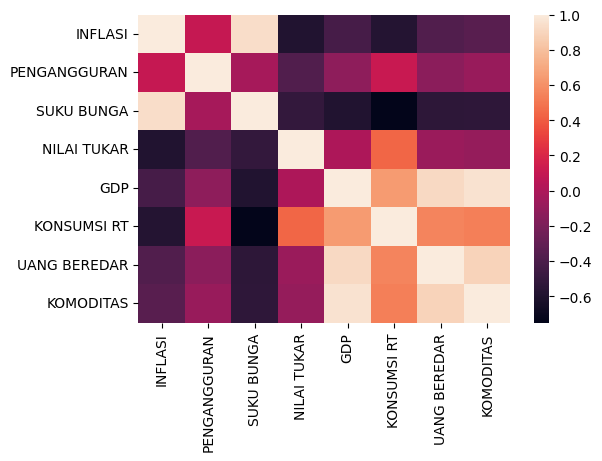

In [12]:
df1 =df.iloc[:, 1:] 
corr_matrix = df1.corr()
corr_matrix
fig = plt.figure(figsize=(6,4))
sns.heatmap(corr_matrix)

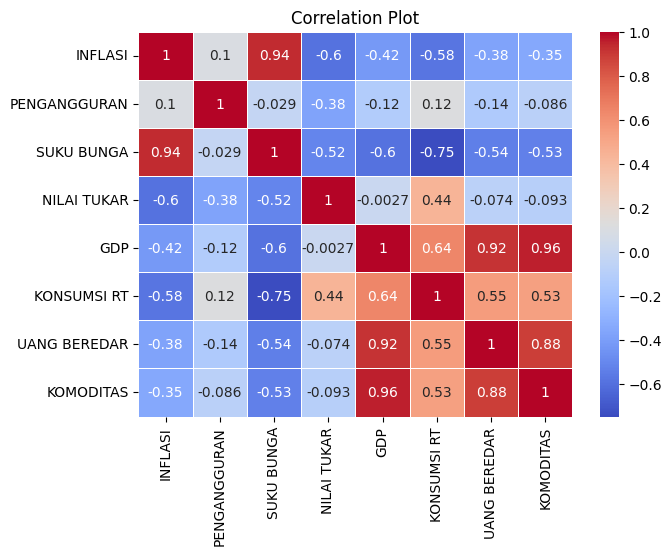

In [13]:
plt.figure(figsize=(7, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Plot')
plt.show()

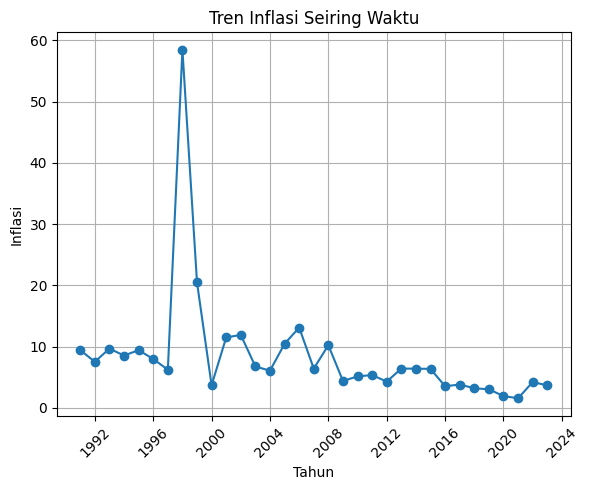

In [14]:
df['DATE'] = pd.to_datetime(df['DATE'])

plt.figure(figsize=(6, 5))
plt.plot(df['DATE'], df['INFLASI'], marker='o', linestyle='-')
plt.title('Tren Inflasi Seiring Waktu')
plt.xlabel('Tahun')
plt.ylabel('Inflasi')
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()

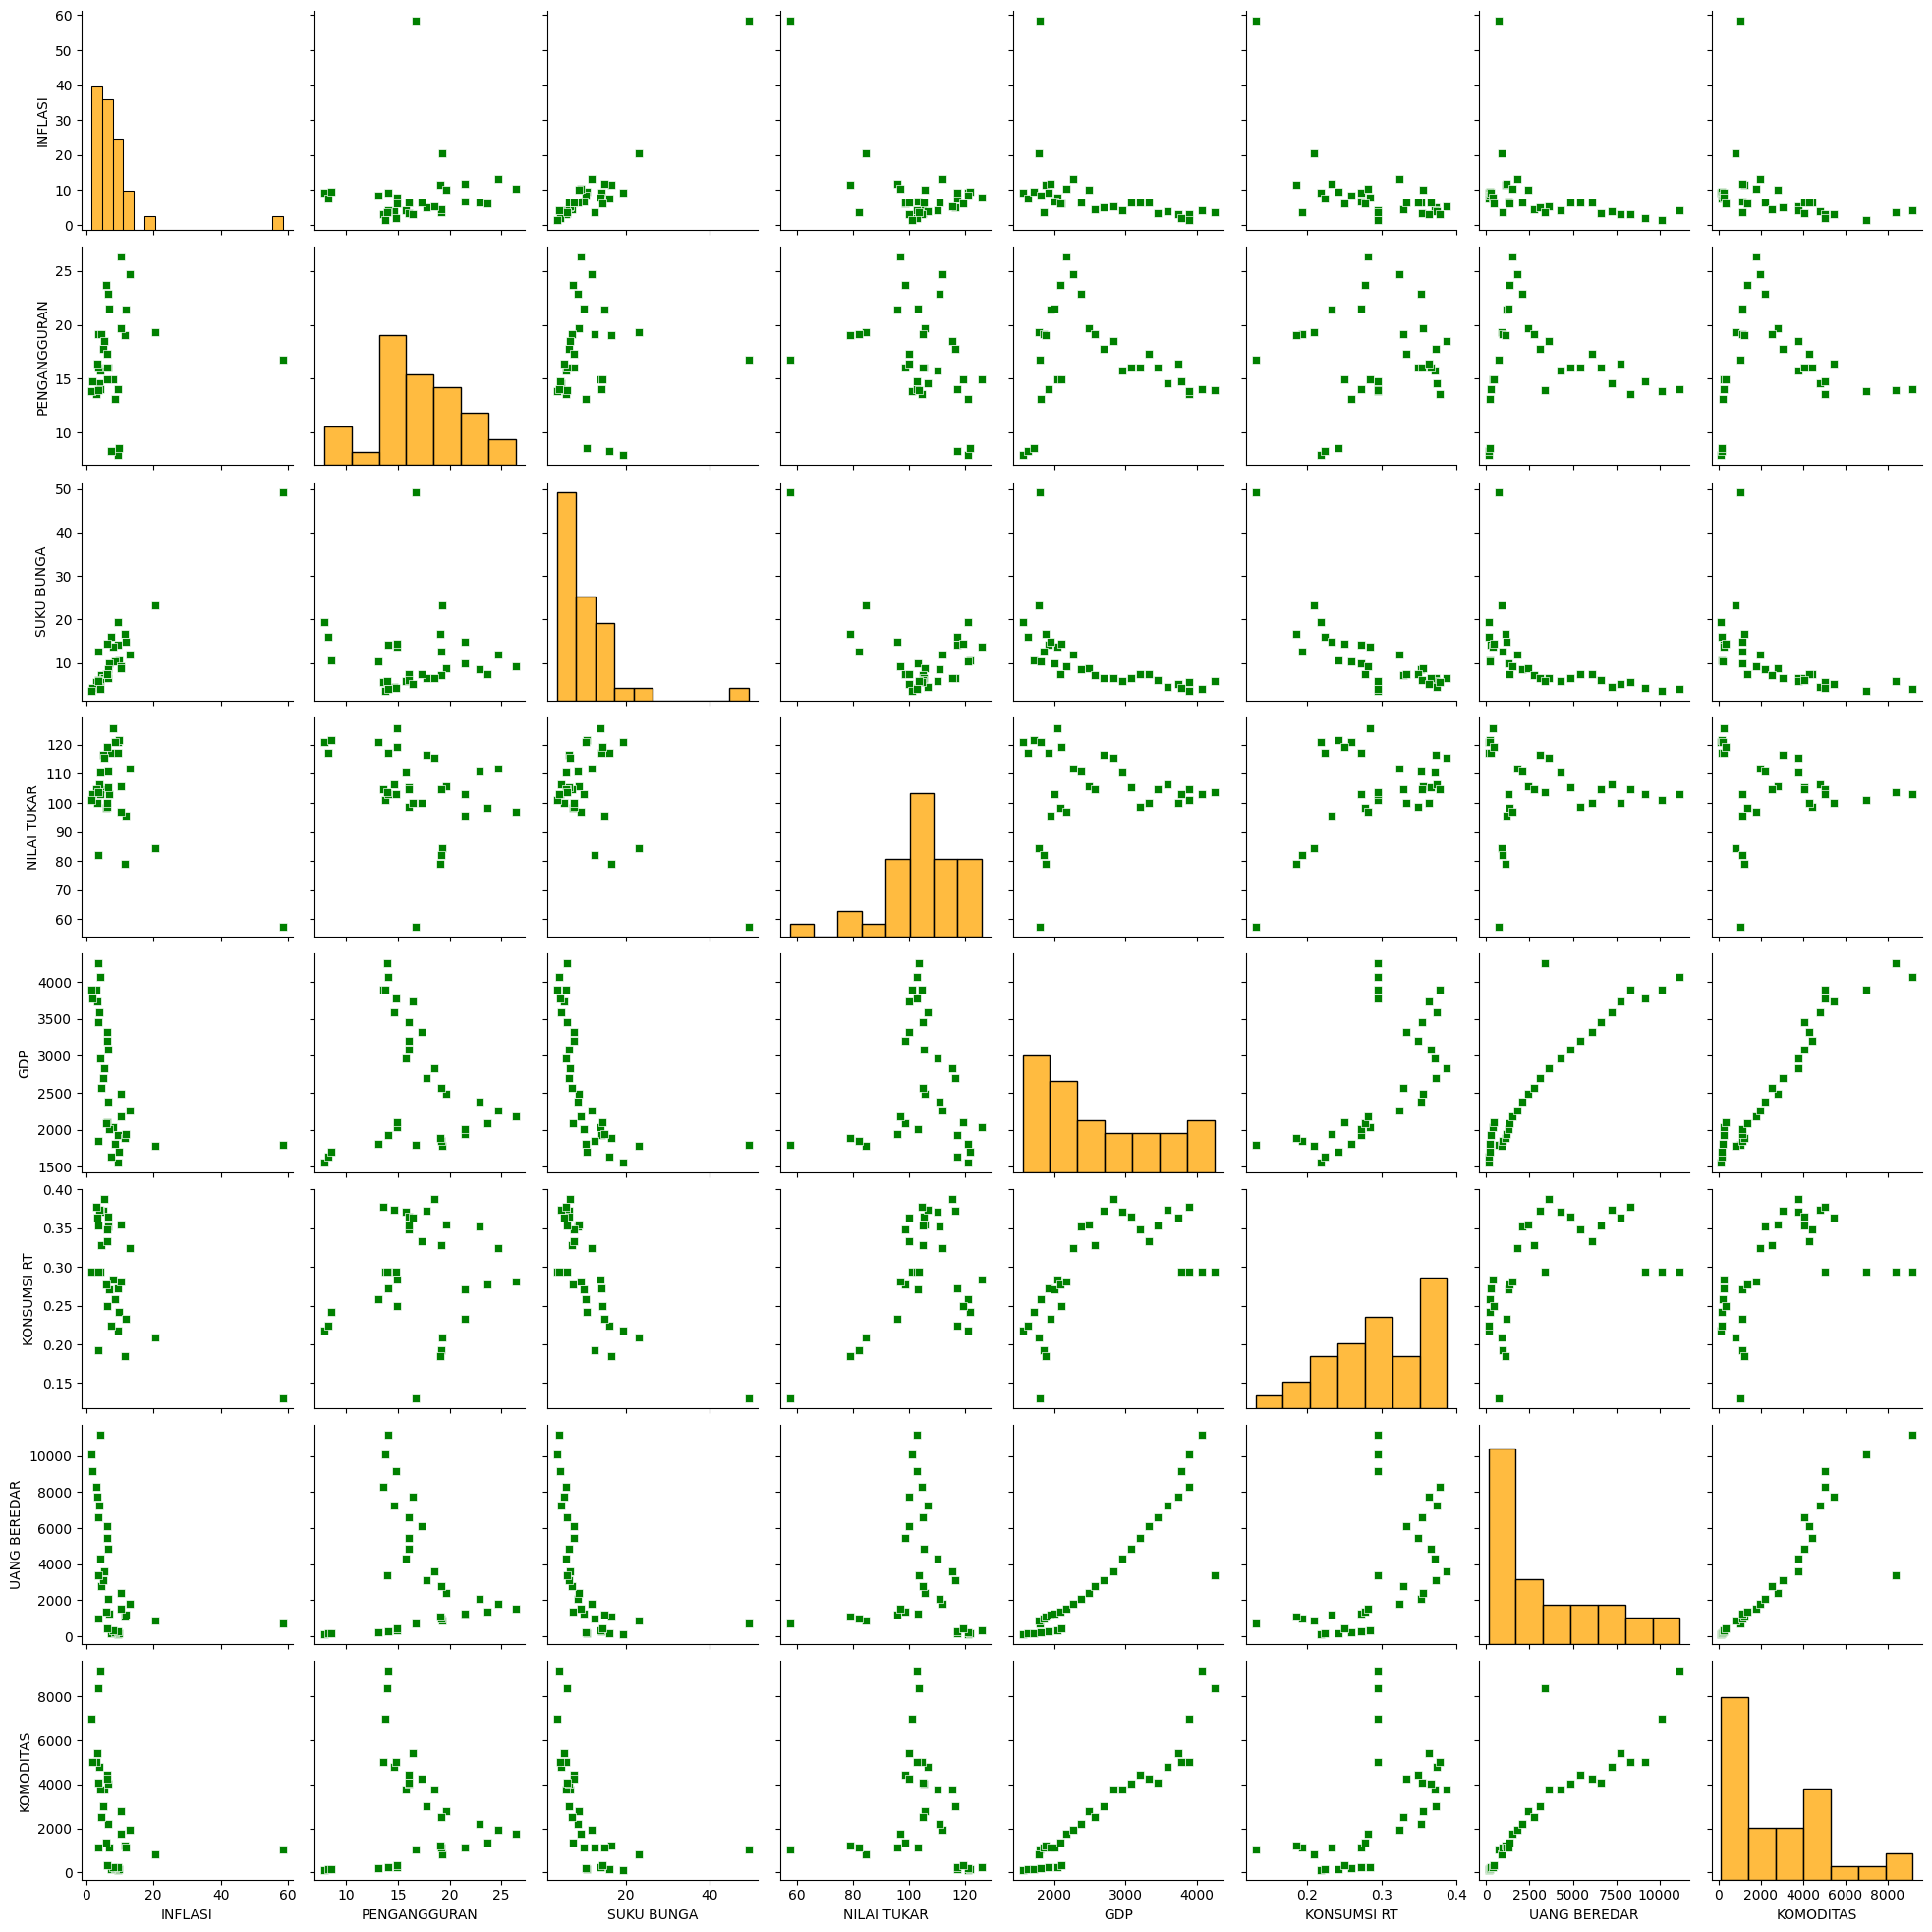

In [15]:
sns.pairplot(df,
plot_kws = {'color': 'green', 'marker': 's'},
             diag_kws = {'color': 'orange'})

### UJI MULTIKOLINIERITAS

In [16]:
x = df[['PENGANGGURAN',	'SUKU BUNGA', 'NILAI TUKAR', 'GDP', 'KONSUMSI RT','UANG BEREDAR','KOMODITAS']]
y = df['INFLASI']

model = smf.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                INFLASI   R-squared (uncentered):                   0.966
Model:                            OLS   Adj. R-squared (uncentered):              0.957
Method:                 Least Squares   F-statistic:                              104.9
Date:                Mon, 23 Sep 2024   Prob (F-statistic):                    2.03e-17
Time:                        21:31:30   Log-Likelihood:                         -75.348
No. Observations:                  33   AIC:                                      164.7
Df Residuals:                      26   BIC:                                      175.2
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
PENGANGGURAN     0.0407      0.110      0.371      0.714      -0.185       0.266
SUKU BUNGA       1.2394      0.074     16.762      0.000       1.087       1.391
NILAI TUKAR     -0.1065      0.036     -2.948      0.007      -0.181      -0.032
GDP             -0.0044      0.003     -1.749      0.092      -0.010       0.001
KONSUMSI RT     42.6934     14.289      2.988      0.006      13.323      72.064
UANG BEREDAR     0.0002      0.000      0.467      0.644      -0.001       0.001
KOMODITAS        0.0014      0.001      1.952      0.062   -7.52e-05       0.003
==============================================================================
Omnibus:                        2.126   Durbin-Watson:                   1.354
Prob(Omnibus):                  0.346   Jarque-Bera (JB):                1.002
Skew:                           0.218   Prob(JB):                        0.606
Kurtosis:                       3.734   Cond. No.                     1.96e+05
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 1.96e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
y_pred = model.predict(x) 
error = y-y_pred 
gab= pd.DataFrame({'Actual': y,  'Predicted': y_pred, 'Error':error}) 
gab.head(10)

,Actual,Predicted,Error
0,9.419058,14.009559,-4.590501
1,7.523517,10.256815,-2.733298
2,9.671893,3.595248,6.076645
3,8.532005,3.804503,4.727503
4,9.420323,9.093761,0.326563
5,7.973281,7.889303,0.083977
6,6.226142,7.800879,-1.574738
7,58.451044,54.961415,3.489630
8,20.477831,22.819248,-2.341417
9,3.688619,9.418032,-5.729413


In [18]:
meanAbErr = metrics.mean_absolute_error(y, y_pred) 
meanSqErr = metrics.mean_squared_error(y, y_pred) 
rootMeanSqErr = np.sqrt(metrics.mean_squared_error(y, y_pred)) 
print('Mean Absolute Error:', meanAbErr) 
print('Mean Square Error:', meanSqErr) 
print('Root Mean Square Error:', rootMeanSqErr)

Mean Absolute Error: 1.7039429970069424
Mean Square Error: 5.633000561601651
Root Mean Square Error: 2.373394312288131


In [19]:
vif_data = pd.DataFrame() 
vif_data["feature"] = x.columns 
vif_data["VIF"] = [variance_inflation_factor(x.values, i) 
    for i in range(len(x.columns))] 
print(vif_data)

        feature         VIF
0  PENGANGGURAN   16.692923
1    SUKU BUNGA    4.679630
2   NILAI TUKAR   66.816592
3           GDP  222.735908
4   KONSUMSI RT   85.576432
5  UANG BEREDAR   14.741588
6     KOMODITAS   33.445765


#### SOLUSI 1

In [20]:
pca = PCA() 
xr=pca.fit_transform(scale(x))

In [21]:
xr = pd.DataFrame (xr) 
vif_data_r = pd.DataFrame() 
vif_data_r["feature"] = x.columns 
vif_data_r["VIF"] = [variance_inflation_factor(xr.values, i) 
    for i in range(len(xr.columns))] 
vif_data_r

,feature,VIF
0,PENGANGGURAN,1.0
1,SUKU BUNGA,1.0
2,NILAI TUKAR,1.0
3,GDP,1.0
4,KONSUMSI RT,1.0
5,UANG BEREDAR,1.0
6,KOMODITAS,1.0


In [22]:
xr = smf.add_constant(xr)
modelPCA= smf.OLS(y,xr).fit()
modelPCA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                INFLASI   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                     61.41
Date:                Mon, 23 Sep 2024   Prob (F-statistic):           3.60e-14
Time:                        21:31:30   Log-Likelihood:                -73.590
No. Observations:                  33   AIC:                             163.2
Df Residuals:                      25   BIC:                             175.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.5167      0.450     18.923      0.000       7.590       9.444
0              3.0802      0.230     13.387      0.000       2.606       3.554
1              3.9899      0.361     11.054      0.000       3.247       4.733
2             -1.6449      0.424     -3.875      0.001      -2.519      -0.771
3              8.9831      0.905      9.926      0.000       7.119      10.847
4              2.7442      1.248      2.200      0.037       0.175       5.314
5              4.3544      1.489      2.925      0.007       1.288       7.421
6              3.4216      2.775      1.233      0.229      -2.294       9.137
==============================================================================
Omnibus:                        9.161   Durbin-Watson:                   1.497
Prob(Omnibus):                  0.010   Jarque-Bera (JB):                8.362
Skew:                           0.885   Prob(JB):                       0.0153
Kurtosis:                       4.717   Cond. No.                         12.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [23]:
# xr1 = xr
# xr1.pop(4)
# xr1.head()

# modelPCA2 = smf.OLS(y, xr1).fit()
# modelPCA2.summary()

#### SOLUSI 2

In [24]:
alphas = 10**np.linspace(10,-2,100)*0.5 
alphas

array([5.00000000e+09, 3.78231664e+09, 2.86118383e+09, 2.16438064e+09,
       1.63727458e+09, 1.23853818e+09, 9.36908711e+08, 7.08737081e+08,
       5.36133611e+08, 4.05565415e+08, 3.06795364e+08, 2.32079442e+08,
       1.75559587e+08, 1.32804389e+08, 1.00461650e+08, 7.59955541e+07,
       5.74878498e+07, 4.34874501e+07, 3.28966612e+07, 2.48851178e+07,
       1.88246790e+07, 1.42401793e+07, 1.07721735e+07, 8.14875417e+06,
       6.16423370e+06, 4.66301673e+06, 3.52740116e+06, 2.66834962e+06,
       2.01850863e+06, 1.52692775e+06, 1.15506485e+06, 8.73764200e+05,
       6.60970574e+05, 5.00000000e+05, 3.78231664e+05, 2.86118383e+05,
       2.16438064e+05, 1.63727458e+05, 1.23853818e+05, 9.36908711e+04,
       7.08737081e+04, 5.36133611e+04, 4.05565415e+04, 3.06795364e+04,
       2.32079442e+04, 1.75559587e+04, 1.32804389e+04, 1.00461650e+04,
       7.59955541e+03, 5.74878498e+03, 4.34874501e+03, 3.28966612e+03,
       2.48851178e+03, 1.88246790e+03, 1.42401793e+03, 1.07721735e+03,
      

In [25]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
ridge = Ridge()
coefs = []

for a in alphas:
    ridge.set_params(alpha=a)
    ridge.fit(x_scaled, y)  
    coefs.append(ridge.coef_)
print(np.shape(coefs))

(100, 7)


Text(0, 0.5, 'weights')

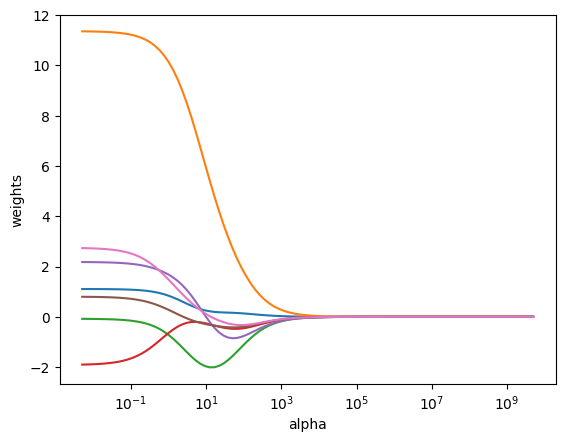

In [26]:
ax = plt.gca() 
ax.plot(alphas, coefs) 
ax.set_xscale('log') 
plt.axis('tight') 
plt.xlabel('alpha') 
plt.ylabel('weights')

In [27]:
alphas = [None]

for alpha in alphas:
    if alpha is None:
        ridge = RidgeCV(alphas=[0.1, 0.5, 1, 2, 4, 10])  
        ridge.fit(x_scaled, y)
        best_alpha = ridge.alpha_ 
        print(f"Best Alpha (RidgeCV): {best_alpha}")
    else:
        ridge = Ridge(alpha=alpha)
        ridge.fit(x_scaled, y)
        best_alpha = alpha
    pred_ridge = ridge.predict(x_scaled)
    print(f"Mean Squared Error: {mean_squared_error(y, pred_ridge)}") 

Best Alpha (RidgeCV): 0.1
Mean Squared Error: 5.07253621995745


In [28]:
pd.Series(ridge.coef_, index=x.columns)

PENGANGGURAN     1.079883
SUKU BUNGA      11.221241
NILAI TUKAR     -0.154344
GDP             -1.654165
KONSUMSI RT      2.108974
UANG BEREDAR     0.715633
KOMODITAS        2.518513
dtype: float64

#### SOLUSI 3

In [29]:
alphas = 10**np.linspace(10,-2,100)*0.5 

Text(0, 0.5, 'weights')

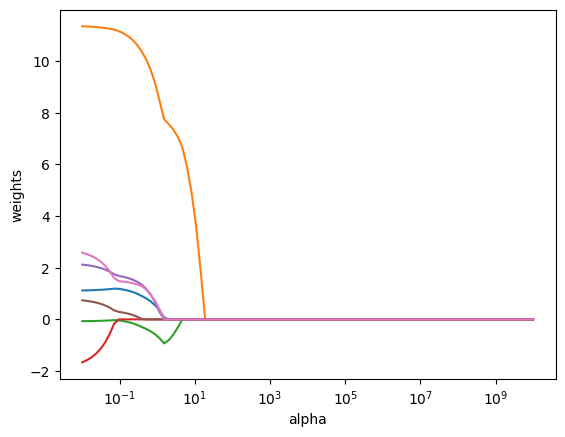

In [30]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

lasso = Lasso(max_iter=10000)
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(scale(x), y) 
    coefs.append(lasso.coef_) 
ax = plt.gca() 
ax.plot(alphas*2, coefs) 
ax.set_xscale('log')
plt.axis('tight') 
plt.xlabel('alpha') 
plt.ylabel('weights')

In [31]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

lasso_cv = LassoCV(alphas=None, cv=10, max_iter=100000)
lasso_cv.fit(x_scaled, y)
best_alpha = lasso_cv.alpha_
lasso = Lasso(alpha=best_alpha, max_iter=10000)
lasso.fit(x_scaled, y)
mse = mean_squared_error(y, lasso.predict(x_scaled))

print(f"Best Alpha (Lasso): {best_alpha}")
print(f"Mean Squared Error: {mse}")

Best Alpha (Lasso): 0.012729369386855026
Mean Squared Error: 5.082137488508964


In [32]:
pd.Series(lasso.coef_, index=x.columns)

PENGANGGURAN     1.138497
SUKU BUNGA      11.311951
NILAI TUKAR     -0.058547
GDP             -1.275194
KONSUMSI RT      2.024076
UANG BEREDAR     0.638501
KOMODITAS        2.326263
dtype: float64

### UJI HETEROKEDASTISITAS

In [33]:
bp_test = het_breuschpagan(modelPCA.resid, modelPCA.model.exog)
bp_labels = ['Statistik LM', 'P-Value LM', 'Statistik F', 'P-Value F']
lzip(bp_labels, bp_test)

[('Statistik LM', 14.784390918884597),
 ('P-Value LM', 0.038864683142145584),
 ('Statistik F', 2.898689574624993),
 ('P-Value F', 0.023117491922286633)]

In [34]:
white_test = het_white(modelPCA.resid, modelPCA.model.exog)
white_labels = ['Statistik LM', 'P-Value LM', 'Statistik F', 'P-Value F']
lzip(white_labels, white_test)

[('Statistik LM', 33.0),
 ('P-Value LM', 0.4180195006078763),
 ('Statistik F', nan),
 ('P-Value F', nan)]

In [35]:
residuals = y - lasso.predict(x_scaled)
# residuals = modelPCA.resid
exog = modelPCA.model.exog

# bp_test = het_breuschpagan(residuals, exog)
# bp_labels = ['Statistik LM', 'P-Value LM', 'Statistik F', 'P-Value F']
# lzip(bp_labels, bp_test)

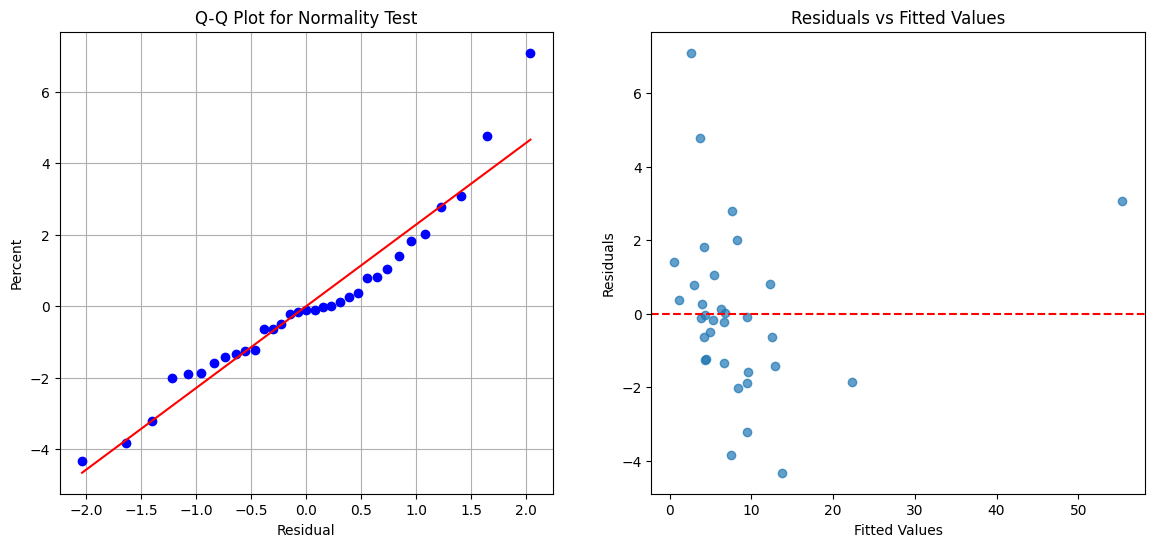

In [36]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 2)
plt.scatter(lasso.predict(x_scaled), residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 1)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normality Test")
plt.xlabel("Residual")
plt.ylabel("Percent")
plt.grid(True)
plt.show()

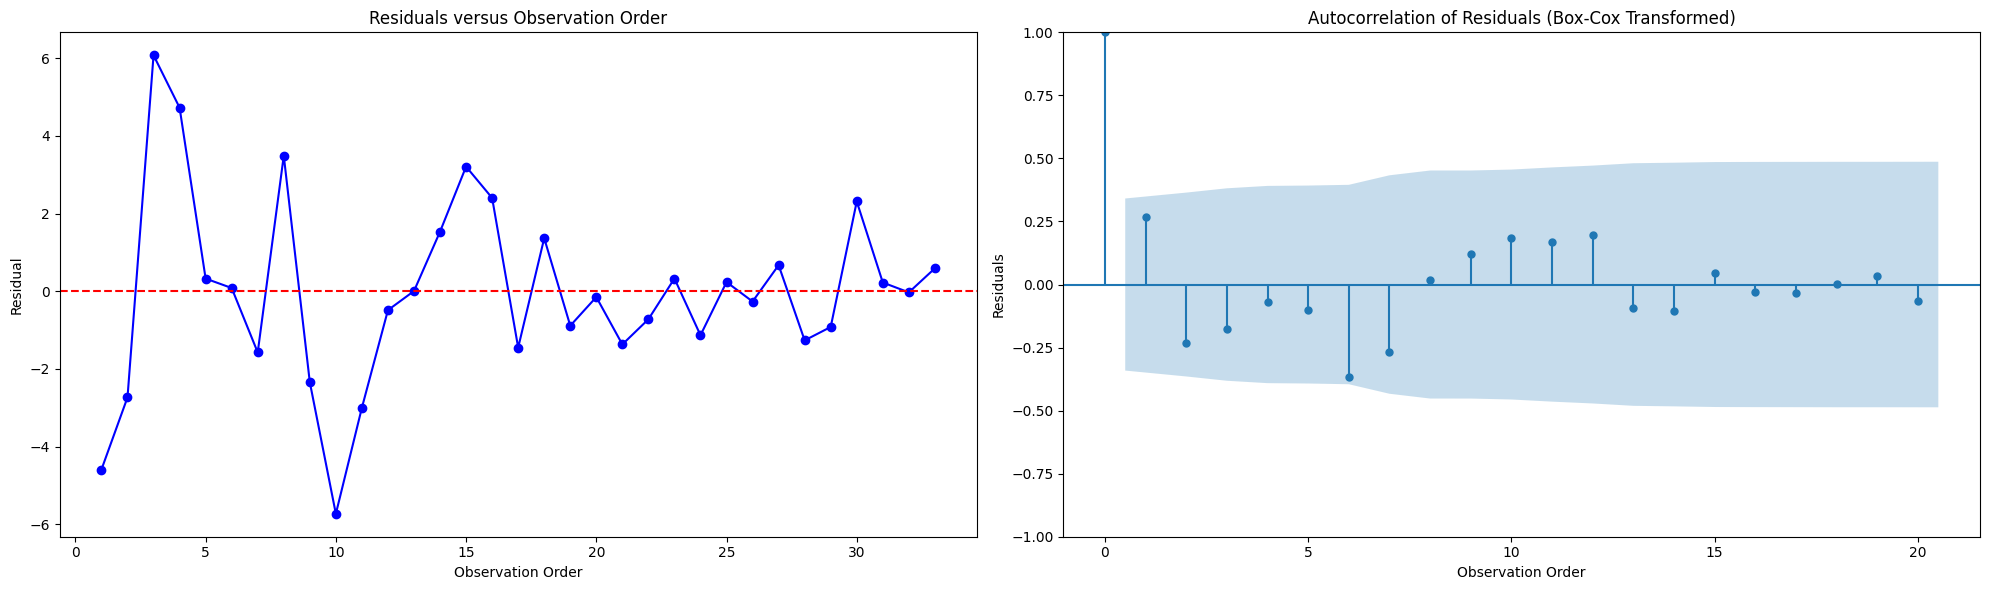

In [37]:
residuals = y - y_pred
# residuals_boxcox, _ = boxcox(residuals + np.abs(np.min(residuals)) + 1)  
observation_order = np.arange(1, len(residuals) + 1)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(observation_order, residuals, marker='o', linestyle='-', color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals versus Observation Order')
plt.xlabel('Observation Order')
plt.ylabel('Residual')

plt.subplot(1, 2, 2)
plot_acf(residuals, lags=20, ax=plt.gca())
plt.title('Autocorrelation of Residuals (Box-Cox Transformed)')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

### transformasi

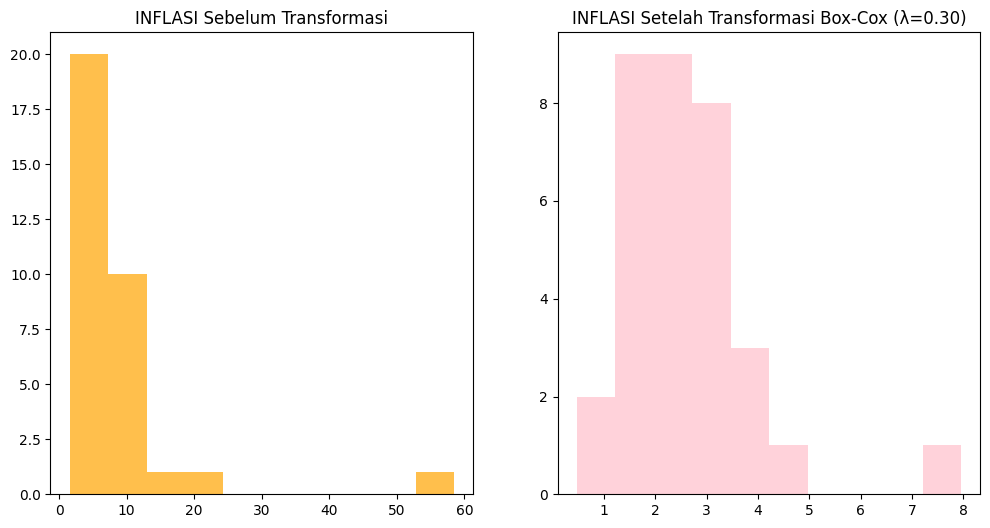

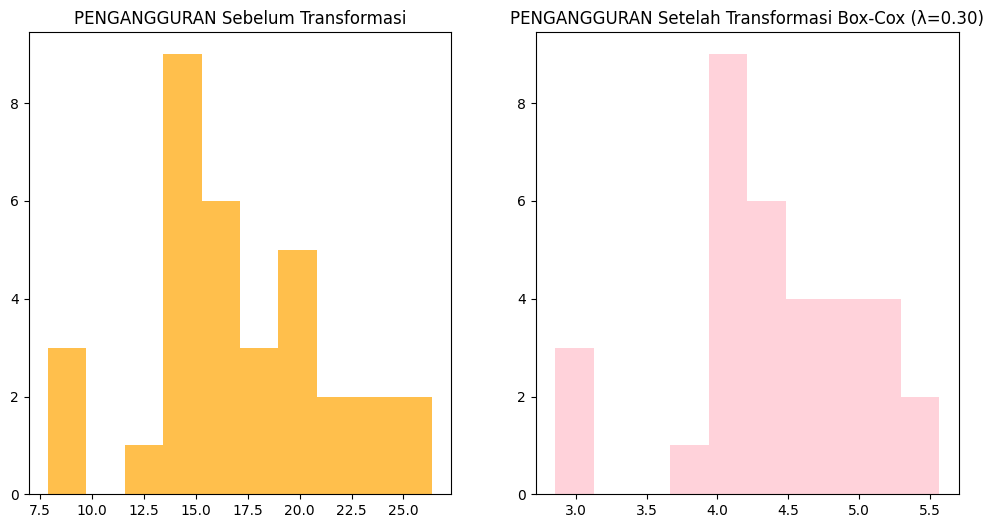

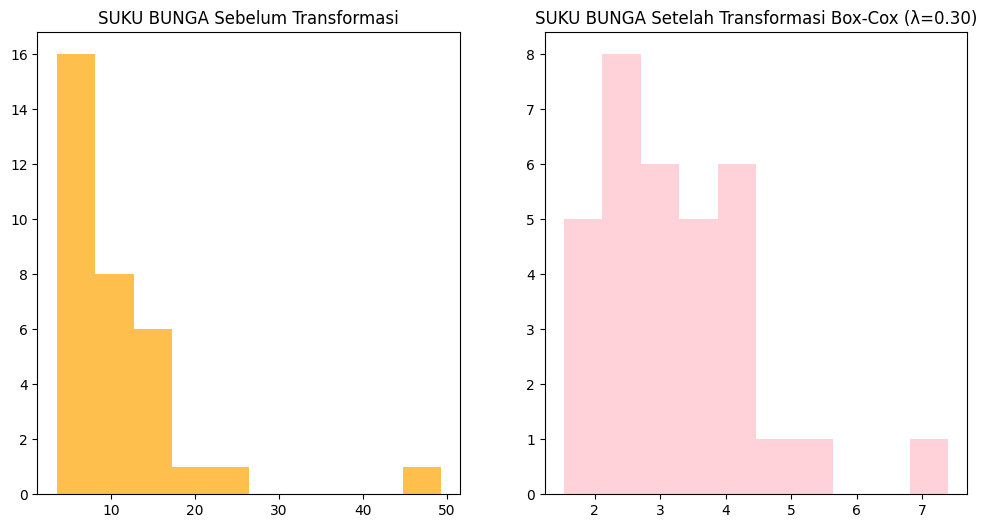

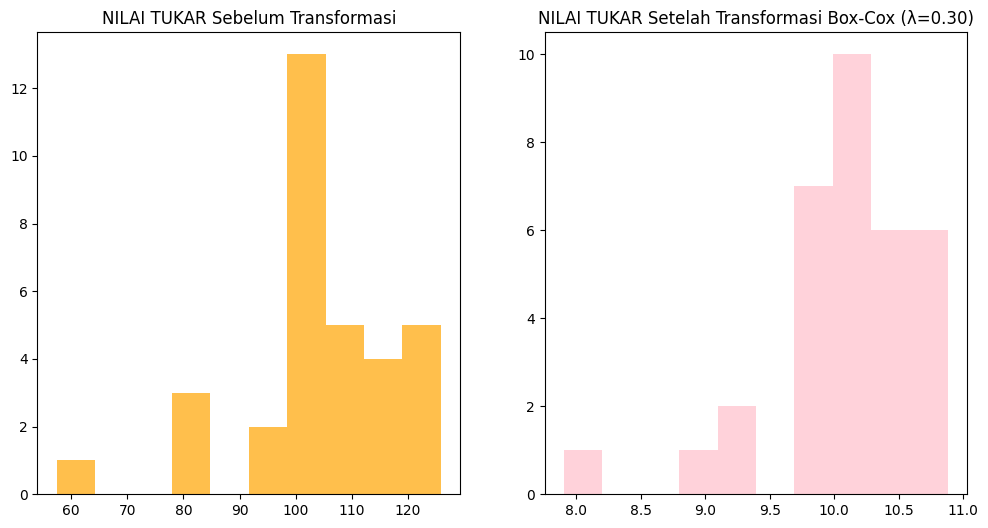

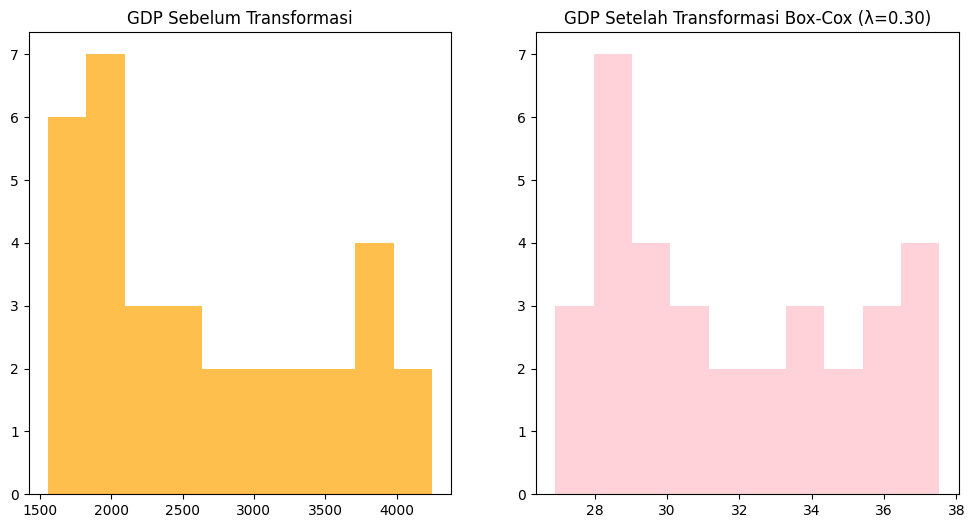

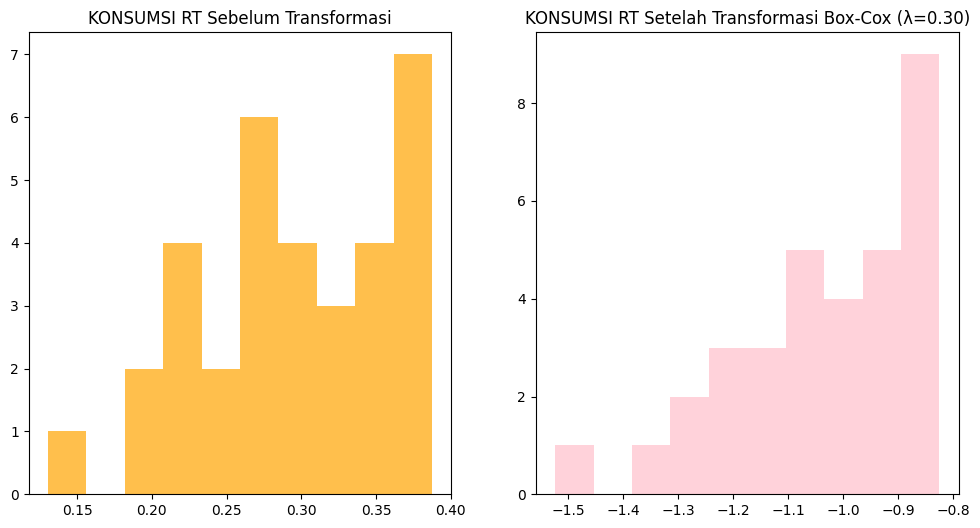

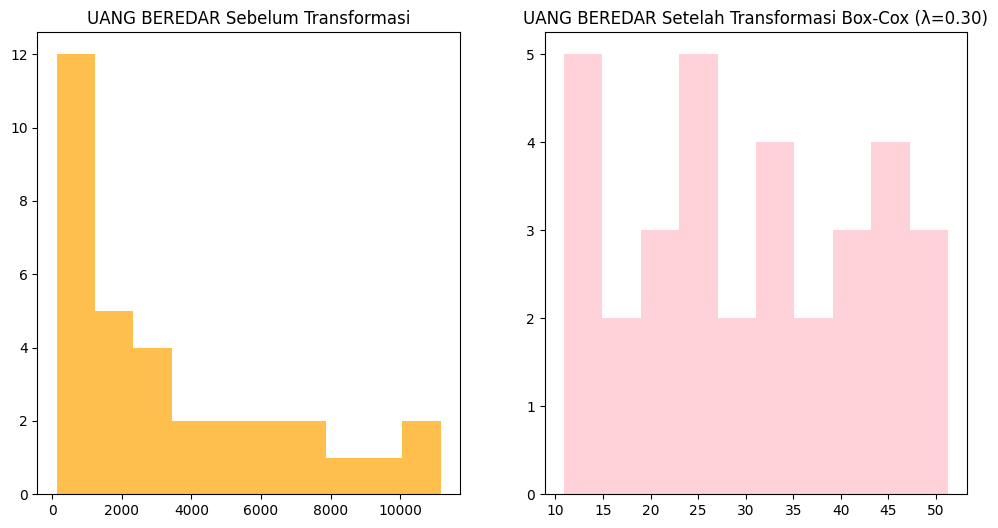

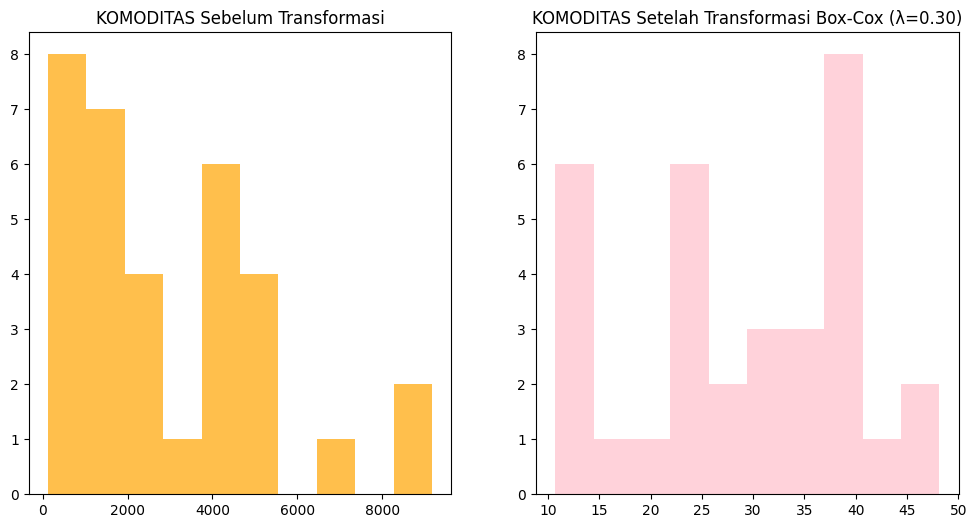

In [38]:
excluded_columns = ['DATE']
lambda_value = 0.30

for kolom in df.columns:
    if kolom not in excluded_columns and np.issubdtype(df[kolom].dtype, np.number):
        transformed_data = stats.boxcox(df[kolom], lmbda=lambda_value)
        df['transformed_' + kolom] = transformed_data
    
        plt.figure(figsize=(12,6))
        plt.subplot(1, 2, 1)
        plt.hist(df[kolom], bins=10, color='orange', alpha=0.7)
        plt.title(f'{kolom} Sebelum Transformasi')
        
        plt.subplot(1, 2, 2)
        plt.hist(df['transformed_' + kolom], bins=10, color='pink', alpha=0.7)
        plt.title(f'{kolom} Setelah Transformasi Box-Cox (λ=0.30)')
        plt.show()

In [39]:
df_transformed = df.copy()
df_transformed.head()

,DATE,INFLASI,PENGANGGURAN,SUKU BUNGA,NILAI TUKAR,GDP,KONSUMSI RT,UANG BEREDAR,KOMODITAS,transformed_INFLASI,transformed_PENGANGGURAN,transformed_SUKU BUNGA,transformed_NILAI TUKAR,transformed_GDP,transformed_KONSUMSI RT,transformed_UANG BEREDAR,transformed_KOMODITAS
0,1991-01-01,9.419058,7.866,19.312500,120.911342,1556.806664,0.217840,125.71635,120.40732,3.199190,2.855445,4.769377,10.714808,26.904394,-1.223149,10.880011,10.697214
1,1992-01-01,7.523517,8.242,15.987500,117.321483,1629.847978,0.223746,152.27847,145.69782,2.773345,2.942747,4.322860,10.588358,27.323188,-1.206147,11.721304,11.523104
2,1993-01-01,9.671893,8.565,10.617500,121.661275,1706.952365,0.241392,181.95688,162.83676,3.251309,3.015544,3.438175,10.740891,27.751258,-1.157150,12.547354,12.027136
3,1994-01-01,8.532005,13.108,10.294167,120.982708,1805.603885,0.259007,220.98952,183.17008,3.008197,3.880061,3.375641,10.717295,28.279651,-1.110678,13.500780,12.579045
4,1995-01-01,9.420323,14.013,14.111667,117.086225,1922.352118,0.272217,275.78751,216.36225,3.199453,4.025993,4.041500,10.579977,28.879478,-1.077259,14.657494,13.394250


Text(0, 0.5, 'Frequency')

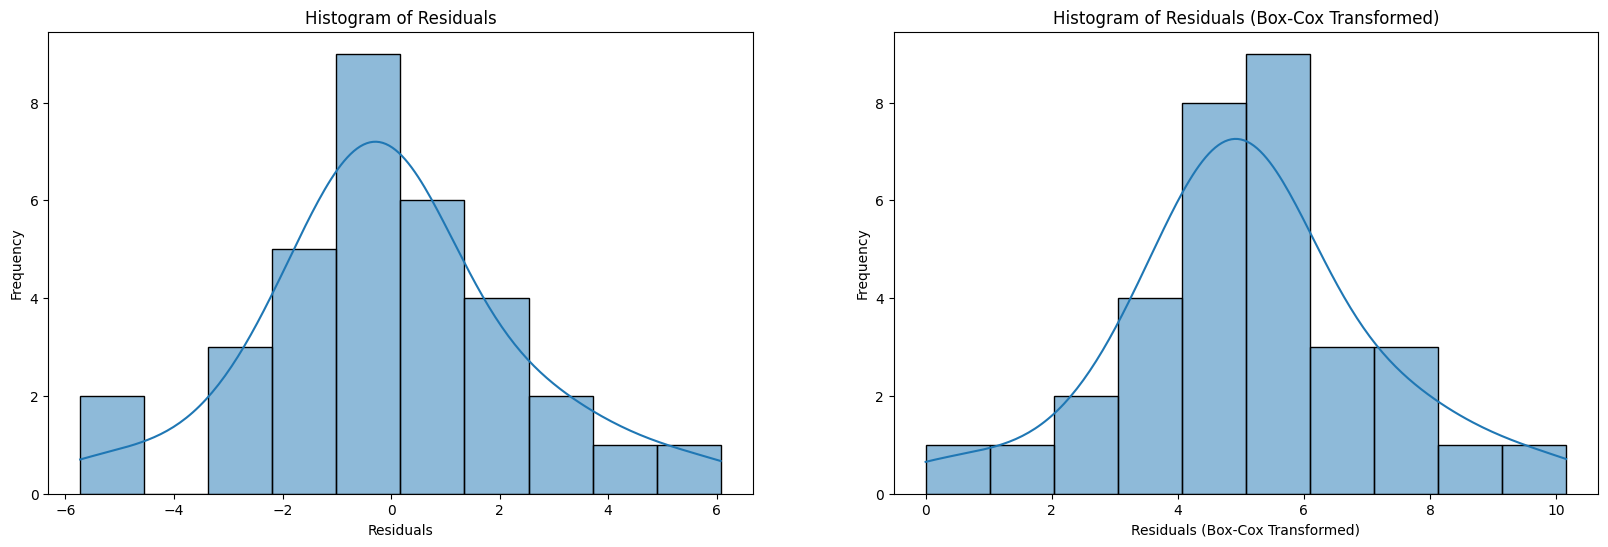

In [40]:
residuals = y - y_pred
residuals_boxcox, _ = boxcox(residuals + np.abs(np.min(residuals)) + 1)  

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
sns.histplot(residuals, kde=True)
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.histplot(residuals_boxcox, kde=True)
plt.title('Histogram of Residuals (Box-Cox Transformed)')
plt.xlabel('Residuals (Box-Cox Transformed)')
plt.ylabel('Frequency')

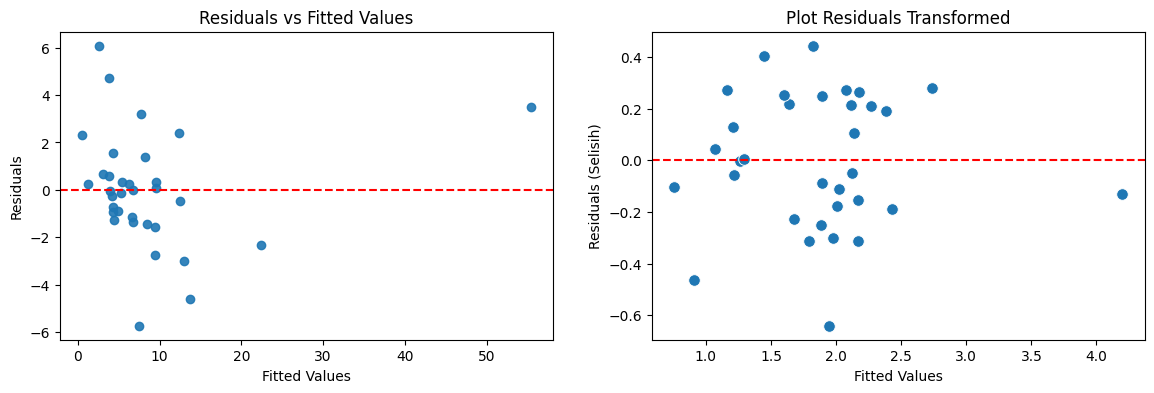

In [41]:
df['PENGANGGURAN_LOG'] = np.log(df['PENGANGGURAN'])  
df['NILAI_TUKAR_LOG'] = np.log(df['NILAI TUKAR']) 
df['KONSUMSI_RT_LOG'] = np.log(df['KONSUMSI RT'])
df['log_inflasi'] = np.log(df['INFLASI'])

X = df[['PENGANGGURAN', 'SUKU BUNGA','GDP', 'NILAI TUKAR', 'KONSUMSI RT', 'UANG BEREDAR', 'KOMODITAS']]
y = df['log_inflasi']
X = smf.add_constant(X)
model_transformed = smf.OLS(y, X).fit()

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.scatter(lasso.predict(x_scaled), residuals, alpha=0.9)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')

plt.subplot(1, 2, 2)
fitted_values = model_transformed.fittedvalues
residuals = model_transformed.resid
sns.scatterplot(x=fitted_values, y=residuals, s=70)
plt.axhline(0, color='red', linestyle='--')
plt.title('Plot Residuals Transformed')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals (Selisih)')
plt.show()

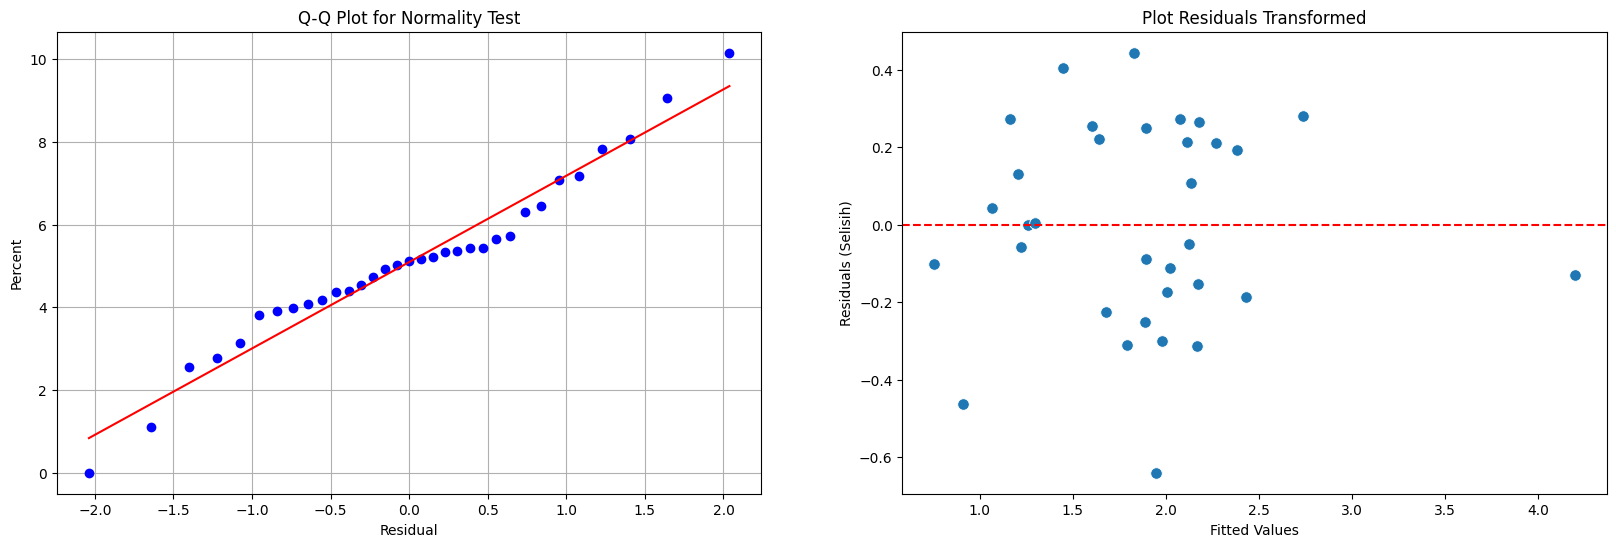

In [42]:
plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
stats.probplot(residuals_boxcox, dist="norm", plot=plt)
plt.title("Q-Q Plot for Normality Test")
plt.xlabel("Residual")
plt.ylabel("Percent")
plt.grid(True)

plt.subplot(1, 2, 2)
fitted_values = model_transformed.fittedvalues
residuals = model_transformed.resid
sns.scatterplot(x=fitted_values, y=residuals, s=70)
plt.axhline(0, color='red', linestyle='--')
plt.title('Plot Residuals Transformed')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals (Selisih)')
plt.show()

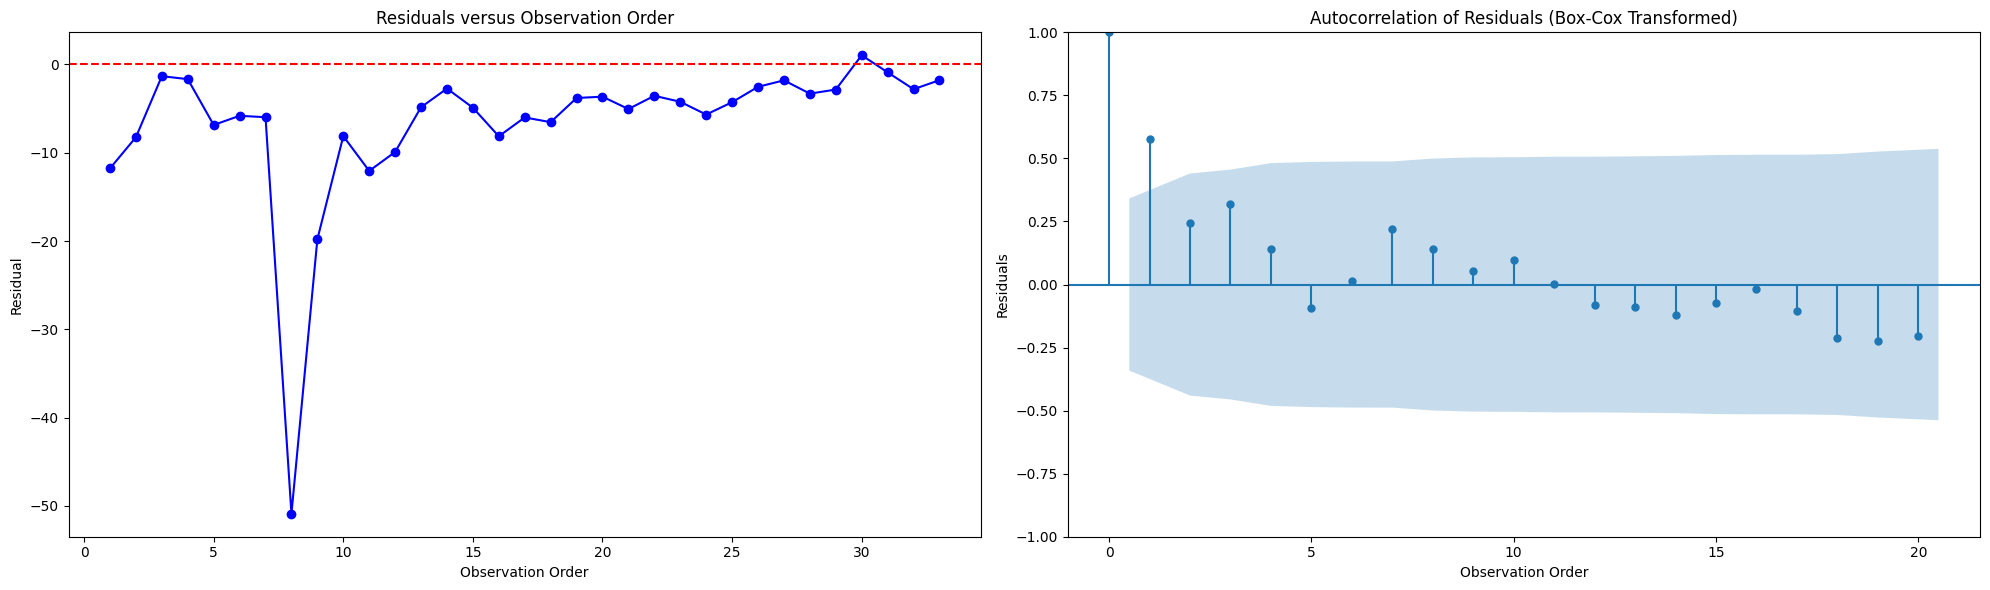

In [43]:
residuals = y - y_pred
residuals_boxcox, _ = boxcox(residuals + np.abs(np.min(residuals)) + 1)  
observation_order = np.arange(1, len(residuals) + 1)

plt.figure(figsize=(20, 6))
plt.subplot(1, 2, 1)
plt.plot(observation_order, residuals, marker='o', linestyle='-', color='blue')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals versus Observation Order')
plt.xlabel('Observation Order')
plt.ylabel('Residual')

plt.subplot(1, 2, 2)
plot_acf(residuals_boxcox, lags=20, ax=plt.gca())
plt.title('Autocorrelation of Residuals (Box-Cox Transformed)')
plt.xlabel('Observation Order')
plt.ylabel('Residuals')
plt.tight_layout()
plt.show()

#### LOG TRANSFORM

In [44]:
weights = 1 / (modelPCA.resid ** 2)

model_wls = smf.WLS(df['INFLASI'], modelPCA.model.exog, weights=weights).fit()
bp_test = het_breuschpagan(model_wls.resid, model_wls.model.exog)
lzip(bp_labels, bp_test)

[('Statistik LM', 13.35669214504877),
 ('P-Value LM', 0.06388006265531039),
 ('Statistik F', 2.4284337596724583),
 ('P-Value F', 0.04815673712285462)]

In [45]:
df['PENGANGGURAN_LOG'] = np.log(df['PENGANGGURAN'])  
df['NILAI_TUKAR_LOG'] = np.log(df['NILAI TUKAR']) 
df['KONSUMSI_RT_LOG'] = np.log(df['KONSUMSI RT'])
df['log_inflasi'] = np.log(df['INFLASI'])

X = df[['PENGANGGURAN', 'SUKU BUNGA','GDP', 'NILAI TUKAR', 'KONSUMSI RT', 
        'UANG BEREDAR', 'KOMODITAS']]
y = df['log_inflasi']
X = smf.add_constant(X)

model_transformed = smf.OLS(y, X).fit()
bp_test = het_breuschpagan(model_transformed.resid, model_transformed.model.exog)
lzip(bp_labels, bp_test)

[('Statistik LM', 12.020069831238564),
 ('P-Value LM', 0.09990078993420527),
 ('Statistik F', 2.0461851150377943),
 ('P-Value F', 0.08866657469984368)]

In [46]:
model_robust = smf.OLS(df['INFLASI'], modelPCA.model.exog).fit(cov_type='HC3')  
bp_test = het_breuschpagan(model_robust.resid, model_robust.model.exog)
lzip(bp_labels, bp_test)

[('Statistik LM', 14.784390918884597),
 ('P-Value LM', 0.038864683142145584),
 ('Statistik F', 2.898689574624993),
 ('P-Value F', 0.023117491922286633)]

### UJI RESIDUAL

In [47]:
jb_test = jarque_bera(residuals)
jb_stat = jb_test[0]  
jb_p_value = jb_test[1]  
print(f"Jarque-Bera Test: Stat = {jb_stat}, p-value = {jb_p_value}")

shapiro_stat, shapiro_p_value = stats.shapiro(residuals)
print(f"Shapiro-Wilk Test: Stat = {shapiro_stat}, p-value = {shapiro_p_value}")

ks_statistic, ks_p_value = stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
print(f'Kolmogorov-Smirnov Test: Stat = {ks_statistic}, p-value: {ks_p_value}')

if jb_p_value > 0.05:
    print("\nJarque-Bera: Data residual mengikuti distribusi normal (fail to reject H0).")
else:
    print("\nJarque-Bera: Data residual tidak mengikuti distribusi normal (reject H0).")

if shapiro_p_value > 0.05:
    print("Shapiro-Wilk: Data residual mengikuti distribusi normal (fail to reject H0).")
else:
    print("Shapiro-Wilk: Data residual tidak mengikuti distribusi normal (reject H0).")

if ks_p_value > 0.05:
    print("Kolmogorov-Smirnov: Data residual mengikuti distribusi normal (fail to reject H0).")
else:
    print("Kolmogorov-Smirnov: Data residual tidak mengikuti distribusi normal (reject H0).")

Jarque-Bera Test: Stat = 487.51045094782, p-value = 1.3754684767572463e-106
Shapiro-Wilk Test: Stat = 0.5425055027008057, p-value = 5.434971583895276e-09
Kolmogorov-Smirnov Test: Stat = 0.27901534939038974, p-value: 0.009173190372291917

Jarque-Bera: Data residual tidak mengikuti distribusi normal (reject H0).
Shapiro-Wilk: Data residual tidak mengikuti distribusi normal (reject H0).
Kolmogorov-Smirnov: Data residual tidak mengikuti distribusi normal (reject H0).


In [48]:
jb_test = jarque_bera(residuals_boxcox)
jb_stat = jb_test[0]  # nilai statistik JB
jb_p_value = jb_test[1]  # p-value JB
print(f"Jarque-Bera Test: Stat = {jb_stat}, p-value = {jb_p_value}")

Jarque-Bera Test: Stat = 15.880385671691903, p-value = 0.000356137795551918


### UJI AUTOKORELASI

In [49]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson Statistic: {dw}')

Durbin-Watson Statistic: 0.832703770947449


In [50]:
df['DATE'] = pd.to_datetime(df['DATE'])
df['INFLASI_LAG'] = df['INFLASI'].shift(1)
df = df.dropna()

X = df[['INFLASI_LAG', 'PENGANGGURAN', 'SUKU BUNGA', 'NILAI TUKAR', 'KONSUMSI RT', 'UANG BEREDAR', 'KOMODITAS']]
y = df['INFLASI']
X = smf.add_constant(X)
model = smf.OLS(y, X).fit()

dw_statistic = smf.stats.durbin_watson(model.resid)
print("Durbin-Watson Statistic:", dw_statistic)

Durbin-Watson Statistic: 1.6523304563079286


In [51]:
X = df_transformed[['transformed_PENGANGGURAN', 'transformed_SUKU BUNGA', 'transformed_NILAI TUKAR', 'transformed_KONSUMSI RT', 'transformed_UANG BEREDAR', 'transformed_KOMODITAS']]
y = df_transformed['transformed_INFLASI']
X = smf.add_constant(X)
model = smf.OLS(y, X).fit()

dw = smf.stats.durbin_watson(model.resid)
print(f'Durbin-Watson Statistic: {dw}')

Durbin-Watson Statistic: 1.9320426772590917


In [52]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     transformed_INFLASI   R-squared:                       0.864
Model:                             OLS   Adj. R-squared:                  0.832
Method:                  Least Squares   F-statistic:                     27.42
Date:                 Mon, 23 Sep 2024   Prob (F-statistic):           4.56e-10
Time:                         21:31:34   Log-Likelihood:                -23.296
No. Observations:                   33   AIC:                             60.59
Df Residuals:                       26   BIC:                             71.07
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.2845      8.285      0.276      0.785     -14.745      19.314
transformed_PENGANGGURAN     0.1340      0.216      0.620      0.540      -0.310       0.578
transformed_SUKU BUNGA       1.2989      0.222      5.846      0.000       0.842       1.756
transformed_NILAI TUKAR     -0.2261      0.503     -0.450      0.656      -1.259       0.807
transformed_KONSUMSI RT      2.4275      1.660      1.462      0.156      -0.985       5.840
transformed_UANG BEREDAR    -0.0236      0.033     -0.708      0.485      -0.092       0.045
transformed_KOMODITAS        0.0374      0.034      1.111      0.277      -0.032       0.107
==============================================================================
Omnibus:                        2.144   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.059
Skew:                           0.041   Prob(JB):                        0.589
Kurtosis:                       3.874   Cond. No.                     4.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
for nlags in range(1, 4):
    bg_test = dg(model, nlags=nlags)
    print(f"\nBreusch-Godfrey Test [order p = {nlags}]")
    print(f'Test statistic: {bg_test[0]}')
    print(f'p-value: {bg_test[1]}')


Breusch-Godfrey Test [order p = 1]
Test statistic: 0.007257407286951345
p-value: 0.9321100083667393

Breusch-Godfrey Test [order p = 2]
Test statistic: 2.5089296009675444
p-value: 0.2852284615161486

Breusch-Godfrey Test [order p = 3]
Test statistic: 2.8654488664093156
p-value: 0.4128388826477005


In [54]:
ljung_box_test = acorr_ljungbox(model.resid, lags=[1], return_df=True)
print(ljung_box_test)

    lb_stat  lb_pvalue
1  0.005923   0.938654


In [55]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.regression import linear_model

In [60]:
model_arima = ARIMA(df['GDP'], order=(1,0,0))  # AR(1) process
model_arima_fit = model_arima.fit()
model_arima_fit.summary()

c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
c:\Program Files\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive pa

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    GDP   No. Observations:                   32
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -201.775
Date:                Mon, 23 Sep 2024   AIC                            409.549
Time:                        21:37:07   BIC                            413.946
Sample:                             0   HQIC                           411.007
                                 - 32                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2662.5337   2999.356      0.888      0.375   -3216.096    8541.163
ar.L1          0.9954      0.043     23.280      0.000       0.912       1.079
sigma2      1.517e+04   7569.043      2.004      0.045     330.051       3e+04
===================================================================================
Ljung-Box (L1) (Q):                   2.33   Jarque-Bera (JB):                87.15
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               1.45   Skew:                            -2.40
Prob(H) (two-sided):                  0.55   Kurtosis:                         9.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [59]:
model_gls = linear_model.GLS(y, X).fit()
model_gls.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             GLS Regression Results                            
===============================================================================
Dep. Variable:     transformed_INFLASI   R-squared:                       0.864
Model:                             GLS   Adj. R-squared:                  0.832
Method:                  Least Squares   F-statistic:                     27.42
Date:                 Mon, 23 Sep 2024   Prob (F-statistic):           4.56e-10
Time:                         21:37:01   Log-Likelihood:                -23.296
No. Observations:                   33   AIC:                             60.59
Df Residuals:                       26   BIC:                             71.07
Df Model:                            6                                         
Covariance Type:             nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.2845      8.285      0.276      0.785     -14.745      19.314
transformed_PENGANGGURAN     0.1340      0.216      0.620      0.540      -0.310       0.578
transformed_SUKU BUNGA       1.2989      0.222      5.846      0.000       0.842       1.756
transformed_NILAI TUKAR     -0.2261      0.503     -0.450      0.656      -1.259       0.807
transformed_KONSUMSI RT      2.4275      1.660      1.462      0.156      -0.985       5.840
transformed_UANG BEREDAR    -0.0236      0.033     -0.708      0.485      -0.092       0.045
transformed_KOMODITAS        0.0374      0.034      1.111      0.277      -0.032       0.107
==============================================================================
Omnibus:                        2.144   Durbin-Watson:                   1.932
Prob(Omnibus):                  0.342   Jarque-Bera (JB):                1.059
Skew:                           0.041   Prob(JB):                        0.589
Kurtosis:                       3.874   Cond. No.                     4.06e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.06e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### UJI NORMALITAS

In [58]:
ks_statistic, ks_p_value = stats.kstest(residuals, 'norm', args=(residuals.mean(), residuals.std()))
print(f'Kolmogorov-Smirnov Statistic: {ks_statistic}')
print(f'Kolmogorov-Smirnov p-value: {ks_p_value}')

Kolmogorov-Smirnov Statistic: 0.27901534939038974
Kolmogorov-Smirnov p-value: 0.009173190372291917
